In [302]:
import time, sys, os
from csv_load import *
sys.path.append('./animations/')
import anim

from scipy.ndimage import median_filter
from scipy.signal import medfilt

# Loading the files
IMPORTANT NOTE: only a couple of files of Visually guided experiments are uploaded in Github due to the size of the files.  
One contains only a single trial in it.  The other contains 9 (short) trials.  

Processing file :  ../files/utf8_2/Visually_Guided_Reaching_-_Child__4_target_-_LEFT_-_10_06.csv
Trials:  1

Trial 1 duration : 4.735 (s)


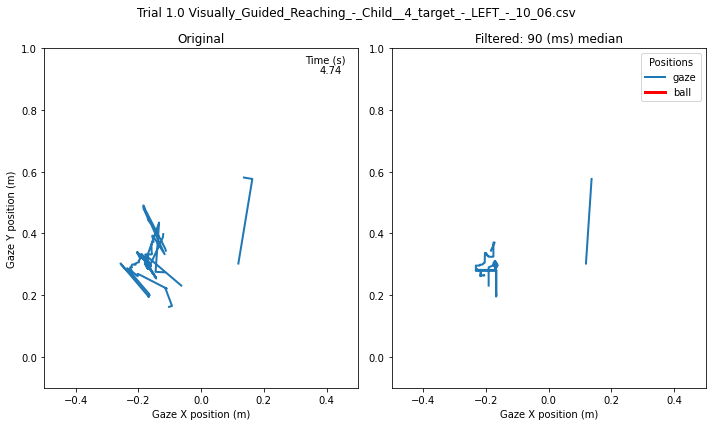

Process finished -- 1.05 seconds --


In [303]:
start_time = time.time()

DIR = "../files/utf8_2/"
FILES = []
for root, dir, files in os.walk(DIR, topdown=False):
    for file in sorted(files):
        FILES.append(os.path.join(root, file))

# Median filter window sizes to test
FILTERS = [90]#, 150, 500]

for f in FILES[9:10]:
    filename = " " + f[16:]
    dfs = extract_dataframes(f, set=2)
    print("Processing file : ", f), print("Trials: ", len(dfs))
    for i in range(len(dfs)):
        trial = Trial(dfs[i], filename)
        #trial.plot_movements()
        print("Trial {} duration : {} (s)".format((i+1), trial.duration))
        for s in FILTERS:
            # animations only work outside of jupyter notebooks, but can still be saved here
            #anim.animate_gaze_single_medfilt(trial, plot=True, save=False, filter=s, speed=1, filename=f[16:21]+str(s))
            anim.static_gaze_single_medfilt(trial, plot=True, save=False, filter=s,filename=f[16:21]+str(s))
    


print("Process finished -- %s seconds --" % round((time.time() - start_time),2))

Further animations and plots are done with the **anim_showcase2.py** script

## Checking for the amount of missing values

In [304]:
file1 = "../files/utf8_2/Visually_Guided_Reaching_-_Child__4_target_-_LEFT_-_10_06.csv"
file2 = "../files/utf8_2/Visually_Guided_Reaching_-_Child__4_target_-_LEFT_-_10_07.csv"
dataframe1 = extract_dataframes(file1, set=2)
dataframes2 = extract_dataframes(file2, set=2)

In [305]:
def check_na(df):
    trials, nax, nay, lengths, percents = [], [], [], [], []
    for i in range(len(df)):
        trials.append(i)
        na_X, na_Y =  df[i]['Gaze_X'].isna().sum(), df[i]['Gaze_Y'].isna().sum()
        nax.append(na_X), nay.append(na_Y)
        lengths.append(len(df[i]))
        percents.append(round(na_X / len(df[i]) * 100, 2))
    d = {'Trial': trials, 'Na X': nax, 'Na Y': nay, 'Total': lengths ,'Na %': percents}
    df_na = pd.DataFrame(d)
    return df_na.set_index('Trial')

df_recap = check_na(dataframe1)
df_recap

,Na X,Na Y,Total,Na %
Trial,,,,
0,798,798,4736,16.85


Mean of missing values for the file1: 

In [306]:
df_recap['Na %'].mean()

16.85

Mean of missing values for the file2:

In [307]:
df_recap = check_na(dataframes2)
df_recap

,Na X,Na Y,Total,Na %
Trial,,,,
0,543,543,3353,16.19
1,980,980,8414,11.65
2,539,539,5857,9.20
3,1132,1132,4838,23.40
4,1299,1299,8258,15.73
5,654,654,6666,9.81
6,2355,2355,8880,26.52
7,200,200,1269,15.76
8,210,210,2586,8.12


In [308]:
df_recap['Na %'].mean()

15.153333333333332

These statistics and animations can be automatically computed for any CSV file (not all are present online).

## Filling the NAs rows

Dataframe with only gaze X,Y and Time

In [309]:
df1 = extract_dataframes(file1, set=2)[0]
df = df1[['Gaze_X', 'Gaze_Y', 'Frame time (s)']]
#for i in range (0,len(df[0]),100):
nona_len = len(df.dropna())

# Original df with the NANs : 
df


,Gaze_X,Gaze_Y,Frame time (s)
0,NaN,NaN,0.000
1,NaN,NaN,0.001
2,NaN,NaN,0.002
3,NaN,NaN,0.003
4,NaN,NaN,0.004
...,...,...,...
4731,-0.179035,0.322264,4.731
4732,-0.179035,0.322264,4.732
4733,-0.179366,0.322114,4.733
4734,-0.179366,0.322114,4.734


Listing the consecutives NAs

In [310]:
# Since X and Y are NAs at the same time, taking either is the same count
na_groups = df['Gaze_X'].notna().cumsum()[df['Gaze_X'].isna()]
lengths_consecutive_na = na_groups.groupby(na_groups).agg(len)
#longest_gap = lengths_consecutive_na.max()
lengths_consecutive_na

Gaze_X
0       204
8       162
960     156
3899    276
Name: Gaze_X, dtype: int64

Starting from 0 we have 204 NANs, then 8 good values, then 162 NANs, then ... 

In [311]:
sum(lengths_consecutive_na)

798

In [312]:
#df.iloc[203]
df.iloc[204]

Gaze_X            0.13665
Gaze_Y            0.58104
Frame time (s)    0.20400
Name: 204, dtype: float64

Not using the median filter from scipy because of inconsistencies in NANs handling

In [313]:
# newdf = pd.DataFrame()
# newdf['filt X'] = median_filter(df['Gaze_X'],7)
# newdf['filt Y'] = median_filter(df['Gaze_Y'],7)
# newdf['Frame time (s)'] = median_filter(df['Frame time (s)'],7)

nanmedian from numpy ignore nans values

In [314]:
def medfilt(df, f):
    """ df: raw dataframe
        f: filter size, in both directions
    """
    newdf = pd.DataFrame()
    arrx, arry = [], []
    for i in range(len(df)):
        arrx.append(np.nanmedian(df['Gaze_X'][i-f:i+f]))
        arry.append(np.nanmedian(df['Gaze_Y'][i-f:i+f]))
    newdf['X filter'], newdf['Y filter'] = arrx, arry
    newdf['Frame time (s)'] = df['Frame time (s)']

    return newdf


In [315]:
df1 = extract_dataframes(file1, set=2)[0]
medfilt(df1, 7)

/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


,X filter,Y filter,Frame time (s)
0,NaN,NaN,0.000
1,NaN,NaN,0.001
2,NaN,NaN,0.002
3,NaN,NaN,0.003
4,NaN,NaN,0.004
...,...,...,...
4731,-0.179034,0.322148,4.731
4732,-0.179034,0.322183,4.732
4733,-0.179034,0.322183,4.733
4734,-0.179035,0.322183,4.734


In [316]:
filt_df = medfilt(df1, 7)
na_groups = filt_df['X filter'].notna().cumsum()[filt_df['X filter'].isna()]
na_groups.groupby(na_groups).agg(len)

/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


X filter
0       198
21      149
986     143
3938    263
Name: X filter, dtype: int64

In [317]:
lengths_consecutive_na2 = na_groups.groupby(na_groups).agg(len)
sum(lengths_consecutive_na2)

753

From 798 NAs we are now at 753 with this filtering.  
With more filtering ? 

In [318]:
filt_df2 = medfilt(df1, 30)
na_groups = filt_df2['X filter'].notna().cumsum()[filt_df2['X filter'].isna()]
lengths_consecutive_na3 = na_groups.groupby(na_groups).agg(len)
sum(lengths_consecutive_na3)

592

Lower, as expected

### Experimental, to be deleted

In [319]:
newdf = pd.DataFrame()
arr = []
for i in range(len(df)):
    arr.append(np.nanmedian(df['Gaze_X'][i-7:i+6]))

newdf['filt 2'] = arr
nona_len # 3938

len(newdf.dropna())


3979

In [320]:
medfilt(df['Gaze_X'], 7)

KeyError: 'Gaze_X'

In [ ]:
x = df['Gaze_X']
x = x[np.logical_not(np.isnan(x))]
fx = medfilt(df['Gaze_X'], 7)
fx = fx[np.logical_not(np.isnan(fx))]
np.shape(fx)

(3938,)

In [ ]:
newdf['filtered'].isnull().values

array([ True,  True,  True, ..., False, False, False])

In [ ]:
# def medfilt(array, f):
#     arr = []
#     for i, j in enumerate(array[:f]):
#         arr.append(np.median(array[:i+f]))
#     for i, j in enumerate(array[f:-f]):
#         #print(array[i:i+2*f])#, j)
#         arr.append(np.median(array[i:i+2*f+1]))
#         print(array[i:i+2*f+1])
#     for i, j in enumerate(array[-f:]):
#         print((array[i-f:]))
#     return arr


# x = [4,5,6,10,3,2,8,9]
# a = medfilt(x, 2)
# a
# #len(a)

In [ ]:
np.shape(np.where(df['Gaze_X'].isnull()))

(1, 798)

In [ ]:
np.shape(np.where(newdf['filtered'].isnull()))

(1, 795)

In [ ]:

z = (np.random.rand(10)*10).round()
z

array([ 4.,  3.,  7.,  5.,  9.,  0.,  0., 10.,  8.,  1.])

In [ ]:
median_filter(z,5)

array([4., 4., 5., 5., 5., 5., 8., 1., 1., 8.])

In [ ]:
def check_na(df):
    trials, nax, nay, lengths, percents = [], [], [], [], []
    for i in range(len(df)):
        trials.append(i)
        na_X, na_Y =  df[i]['Gaze_X'].isna().sum(), df[i]['Gaze_Y'].isna().sum()
        nax.append(na_X), nay.append(na_Y)
        lengths.append(len(df[i]))
        percents.append(round(na_X / len(df[i]) * 100, 2))
    d = {'Trial': trials, 'Na X': nax, 'Na Y': nay, 'Total': lengths ,'Na %': percents}
    df_na = pd.DataFrame(d)
    return df_na.set_index('Trial')